<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Recommendation%20system%20using%20CF%20_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install surprise

     |████████████████████████████████| 11.8MB 6.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670912 sha256=f9d805c7a88e163e28534583ec82f5a79cd13b61c98bd2ab3aeccfde3e9e2ce8
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [3]:
!pip install implicit

     |████████████████████████████████| 1.1MB 6.8MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3420103 sha256=d5cfb9d3f0267df94fb2142723eed5c0ad676e10be62f9a7e02f696a414bc0db
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, SlopeOne, NMF, SVDpp, KNNBaseline, CoClustering, accuracy
from surprise.model_selection import cross_validate
from __future__ import (absolute_import, division, print_function,unicode_literals)
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import sys
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn.preprocessing import MinMaxScaler
import implicit
#import tensorrec

In [5]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving ratings.csv to ratings.csv


In [6]:
# Dataset is now stored in a Pandas Dataframe
import io
rating_data = pd.read_csv(io.BytesIO(uploaded['ratings.csv']))

In [7]:
rating_data.head()

,User_id,Hotel_id,Rating
0,15400,0,1.0
1,3702,1,5.0
2,3738,1,5.0
3,4593,1,5.0
4,4657,1,2.0


In [8]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving hotel_data_final.csv to hotel_data_final.csv


In [10]:
# Dataset is now stored in a Pandas Dataframe
import io
hotel_data = pd.read_csv(io.BytesIO(uploaded['hotel_data_final.csv']))

In [11]:
hotel_data.head()

,Hotel_id,Hotel,Address,City,Title,Users,Reviews,Rating,Hotel_Type,Price,Hotel_Category,User_id
0,0,La Quinta,5820 Walden Rd,Beaumont,This hotel is a dump! Upon ch...,margierodriguez.mcqueen,This hotel is a dump! Upon checking in was tol...,1.0,NaN,NaN,"Lodging,Motels,Hotels,Meeting & Event Planning...",15400
1,1,The Point,Po Box 1327,Saranac Lake,How to Feel like you are truly Royalty!,DrThought,After having stayed at The Point for five days...,5.0,NaN,NaN,"Hotels,Hotel,Restaurants",3702
2,1,The Point,Po Box 1327,Saranac Lake,Not to be missed,Dushi110,The Point exceeds perfection. From the moment ...,5.0,NaN,NaN,"Hotels,Hotel,Restaurants",3738
3,1,The Point,Po Box 1327,Saranac Lake,The most amazing place....,GracieLouNY,My review is long overdue but I tell so many p...,5.0,NaN,NaN,"Hotels,Hotel,Restaurants",4593
4,1,The Point,Po Box 1327,Saranac Lake,Lack of maintenance,Guillen,We were picked up from the airport in a car wh...,2.0,NaN,NaN,"Hotels,Hotel,Restaurants",4657


In [12]:
rating_data.Rating.value_counts()

5.0    11117
4.0     6889
3.0     3228
2.0     1485
1.0     1432
Name: Rating, dtype: int64

In [20]:
List=[]
for i in np.arange(4,5.5, 1):
    M=hotel_data.loc[rating_data[rating_data.Rating==i].Hotel_id.value_counts().head(10).index,'Hotel']
    print('Rate: %f' %i)
    print(M)
    print(' ')

Rate: 4.000000
3113                                        Hotel Abri
9                                            The Point
2189     Americinn Lodge Suites Oscoda - Ausable River
56                                   Inn At Queen Anne
2968                                    Orchid Key Inn
2741                                      Kinzie Hotel
38                                   Inn At Queen Anne
2822                        Aston Waikiki Circle Hotel
3018    Holiday Inn Express New York City Times Square
656       Doubletree By Hilton West Palm Beach Airport
Name: Hotel, dtype: object
 
Rate: 5.000000
2126                                  Super 8 Ithaca
656     Doubletree By Hilton West Palm Beach Airport
38                                 Inn At Queen Anne
9                                          The Point
1462                         Ocean Breeze Motel Apts
2915                         Lemon Tree Hotel Suites
2984                                  Orchid Key Inn
2822                

In [26]:
rating_data[rating_data.Hotel_id==318].Rating.mean()# Average rating for 'Best Western Lamplighter Inn Suites at SDSU'

4.25

In [25]:
rating_data[rating_data.Hotel_id==296].Rating.mean() #Average rating for 'Nob Hill Hotel'


3.1333333333333333

The Hotels with the max number of ratings are:

In [27]:
MaxRating=rating_data['Hotel_id'].value_counts().head(10)

In [28]:
hotel_data.loc[MaxRating.index,'Hotel']


3113                                       Hotel Abri
9                                           The Point
656      Doubletree By Hilton West Palm Beach Airport
38                                  Inn At Queen Anne
2189    Americinn Lodge Suites Oscoda - Ausable River
2126                                   Super 8 Ithaca
2968                                   Orchid Key Inn
2741                                     Kinzie Hotel
1300                   The National Conference Center
2822                       Aston Waikiki Circle Hotel
Name: Hotel, dtype: object

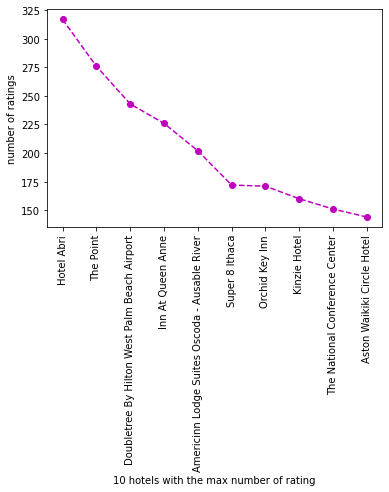

In [29]:
plt.plot(range(len(MaxRating)), MaxRating,'mo--')
plt.xticks(range(len(MaxRating)), hotel_data.loc[MaxRating.index,'Hotel'],rotation=90)
plt.xlabel('10 hotels with the max number of rating')
plt.ylabel('number of ratings')
plt.savefig('foo4.png',dpi=300,bbox_inches='tight')
plt.show()

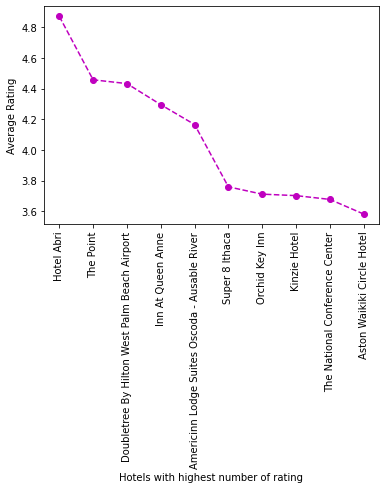

In [30]:
#The Hotels with the highest average rating are:
List5=[]
for i in MaxRating.index:
    List5.append(rating_data[rating_data.Hotel_id==i].R
    ating.mean())
plt.plot(range(len(List5)), sorted(List5,reverse=True),'mo--')
plt.xticks(range(len(List5)), hotel_data.loc[MaxRating.index,'Hotel'],rotation=90)
plt.xlabel('Hotels with highest number of rating')
plt.ylabel('Average Rating')
plt.savefig('foo5.png',dpi=300,bbox_inches='tight')
plt.show()

Number of hotels rated only once

In [31]:
MinRating=rating_data['Hotel_id'].value_counts()
MinRating=MinRating[MinRating==1]
print('Number of hotels which are rated once:',hotel_data.loc[MinRating.index,'Hotel'].shape)

Number of hotels which are rated once: (1189,)


Average rating of the ppl with highest number of rating



In [32]:
ID=hotel_data.User_id.value_counts().head(10) #UserID wih highest number of rating
List5=[]
for i in ID.index:
    List5.append(hotel_data[hotel_data.User_id==i]['Rating'].mean())

List5

[3.8470149253731343,
 3.5388655462184873,
 3.731707317073171,
 3.703125,
 3.8545454545454545,
 3.9074074074074074,
 3.9574468085106385,
 4.0,
 3.8461538461538463,
 3.8846153846153846]

Recommender System

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(hotel_data[['User_id','Hotel_id']],hotel_data['Rating'],test_size=0.25, 
                                                  random_state=55)

y_train=pd.DataFrame(y_train)
train=X_train.join(y_train)

y_test=pd.DataFrame(y_test)
test=X_test.join(y_test)

In [36]:
hotel_data=hotel_data[['User_id','Hotel_id','Rating','City','Hotel']]
hotel_data.head()

,User_id,Hotel_id,Rating,City,Hotel
0,15400,0,1.0,Beaumont,La Quinta
1,3702,1,5.0,Saranac Lake,The Point
2,3738,1,5.0,Saranac Lake,The Point
3,4593,1,5.0,Saranac Lake,The Point
4,4657,1,2.0,Saranac Lake,The Point


The list of the 10 best Hotels to recommend in 'San Francisco' are:

In [40]:
a=hotel_data[hotel_data.City=='San Francisco'].Hotel_id.value_counts().head(30).index
count=0
for i in a:
    if (hotel_data[(hotel_data.Hotel_id==i)].Rating.mean()>4.1)&(count<10):
        count+=1
        print(count,':',hotel_data[(hotel_data.City=='San Francisco')&(hotel_data.Hotel_id==i)].Hotel.iloc[0])

1 : Galleria Park Hotel
2 : Hotel Abri
3 : The Orchard Garden Hotel
4 : The St. Regis San Francisco
5 : Columbus Motor Inn
6 : InterContinental San Francisco
7 : Hotel Nikko San Francisco
8 : Kensington Park Hotel
9 : San Francisco Marriott Marquis
10 : Inn San Francisco


The list of the 10 best Hotels to recommend in 'San Diego' are:

In [41]:
a=hotel_data[hotel_data.City=='San Diego'].Hotel_id.value_counts().head(30).index
count=0
for i in a:
    if (hotel_data[(hotel_data.Hotel_id==i)].Rating.mean()>3)&(count<10):
        count+=1
        print(count,':',hotel_data[(hotel_data.City=='San Diego')&(hotel_data.Hotel_id==i)].Hotel.iloc[0])

1 : Best Western Seven Seas
2 : Hampton Inn San Diego Del Mar
3 : Ocean Park Inn
4 : The Pearl Hotel
5 : Best Western Mission Bay
6 : Best Western Yacht Harbor Hotel
7 : Best Western San Diego/Miramar Hotel
8 : Best Western Plus Hacienda Hotel Old Town
9 : Best Western Plus Bayside Inn
10 : Quality Suites San Diego SeaWorld Area


In [45]:
a=hotel_data[hotel_data.City=='Bengaluru'].Hotel_id.value_counts().head(30).index
count=0
for i in a:
    if (hotel_data[(hotel_data.Hotel_id==i)].Rating.mean()>4)&(count<10):
        count+=1
        print(count,':',hotel_data[(hotel_data.City=='Bengaluru')&(hotel_data.Hotel_id==i)].Hotel.iloc[0])

1 : Shreyas Yoga Retreat
2 : Zone by the Park Electronic City
3 : Treebo Trend Rajathadri Palace
4 : Wonderla Resort
5 : Fortune Park JP Celestial
6 : Sheraton Grand Bengaluru Whitefield Hotel & Convention Center
7 : Royal Orchid Resort & Convention Centre
8 : Gokulam Grand Hotel & Spa
9 : Signature Club Resort
10 : Fairfield by Marriott Bengaluru Rajajinagar
